In [1]:
import psycopg2
from concurrent.futures import ThreadPoolExecutor
from threading import Lock
import time
import math
import matplotlib.pyplot as plt
from dotenv import dotenv_values

Конфігурація та підключення до бази даних

In [2]:
lock = Lock()

config = dotenv_values('.env')
conn = psycopg2.connect(
   database=config['POSTGRES_DB'],
   user=config['POSTGRES_USER'], 
   password=config['POSTGRES_PASSWORD'], 
   host=config['POSTGRES_HOST'], 
   port=config['POSTGRES_PORT']
)

Тестові операції для роботи з СУБД

In [3]:

def transfer_funds(from_account, to_account, amount):
    with conn.cursor() as cur:
        cur.execute('SELECT balance FROM accounts WHERE id = %s', (from_account,))
        from_balance = cur.fetchone()[0]
        
        if from_balance < amount:
            raise ValueError('Insufficient balance')
        
        lock.acquire()
        cur.execute('UPDATE accounts SET balance = balance - %s WHERE id = %s', (amount, from_account))
        cur.execute('UPDATE accounts SET balance = balance + %s WHERE id = %s', (amount, to_account))
        conn.commit()
        lock.release()

def credit_funds(to_account_name, amount):
    with conn.cursor() as cur:
        lock.acquire()
        cur.execute('UPDATE accounts SET balance = balance + %s WHERE name = %s', (amount, to_account_name))
        conn.commit()
        lock.release()

Бенчмарк

In [4]:
def run_transactions(num_threads, num_transactions):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        start_time = time.time()
        
        for _ in range(num_transactions):
            futures.append(executor.submit(lambda: transfer_funds(1, 2, 10)))
            futures.append(executor.submit(lambda: transfer_funds(2, 3, 10)))
            futures.append(executor.submit(lambda: transfer_funds(3, 4, 10)))

        for _ in range(math.floor(num_transactions / 2)):
            futures.append(executor.submit(lambda: credit_funds('Max', 10)))
            futures.append(executor.submit(lambda: credit_funds('John', 10)))
        
        for future in futures:
            future.result()

        executor.shutdown()
        
        end_time = time.time()
        return end_time - start_time

Main

In [10]:
num_threads = 50
num_transactions = 100
iterations = 50
times = []
for i in range(iterations):
    time_taken = run_transactions(num_threads, num_transactions)
    times.append(time_taken)
    print(f'Completed {num_transactions + num_transactions / 2} transactions in {i+1} iteration in {time_taken:.4f} seconds')

Completed 150.0 transactions in 1 iteration in 0.3445 seconds
Completed 150.0 transactions in 2 iteration in 0.3645 seconds
Completed 150.0 transactions in 3 iteration in 0.3193 seconds
Completed 150.0 transactions in 4 iteration in 0.3215 seconds
Completed 150.0 transactions in 5 iteration in 0.3660 seconds
Completed 150.0 transactions in 6 iteration in 0.3437 seconds
Completed 150.0 transactions in 7 iteration in 0.3503 seconds
Completed 150.0 transactions in 8 iteration in 0.3518 seconds
Completed 150.0 transactions in 9 iteration in 0.3280 seconds
Completed 150.0 transactions in 10 iteration in 0.3284 seconds
Completed 150.0 transactions in 11 iteration in 0.3425 seconds
Completed 150.0 transactions in 12 iteration in 0.3132 seconds
Completed 150.0 transactions in 13 iteration in 0.2939 seconds
Completed 150.0 transactions in 14 iteration in 0.4735 seconds
Completed 150.0 transactions in 15 iteration in 0.3885 seconds
Completed 150.0 transactions in 16 iteration in 0.3381 seconds
C

Побудова графіків

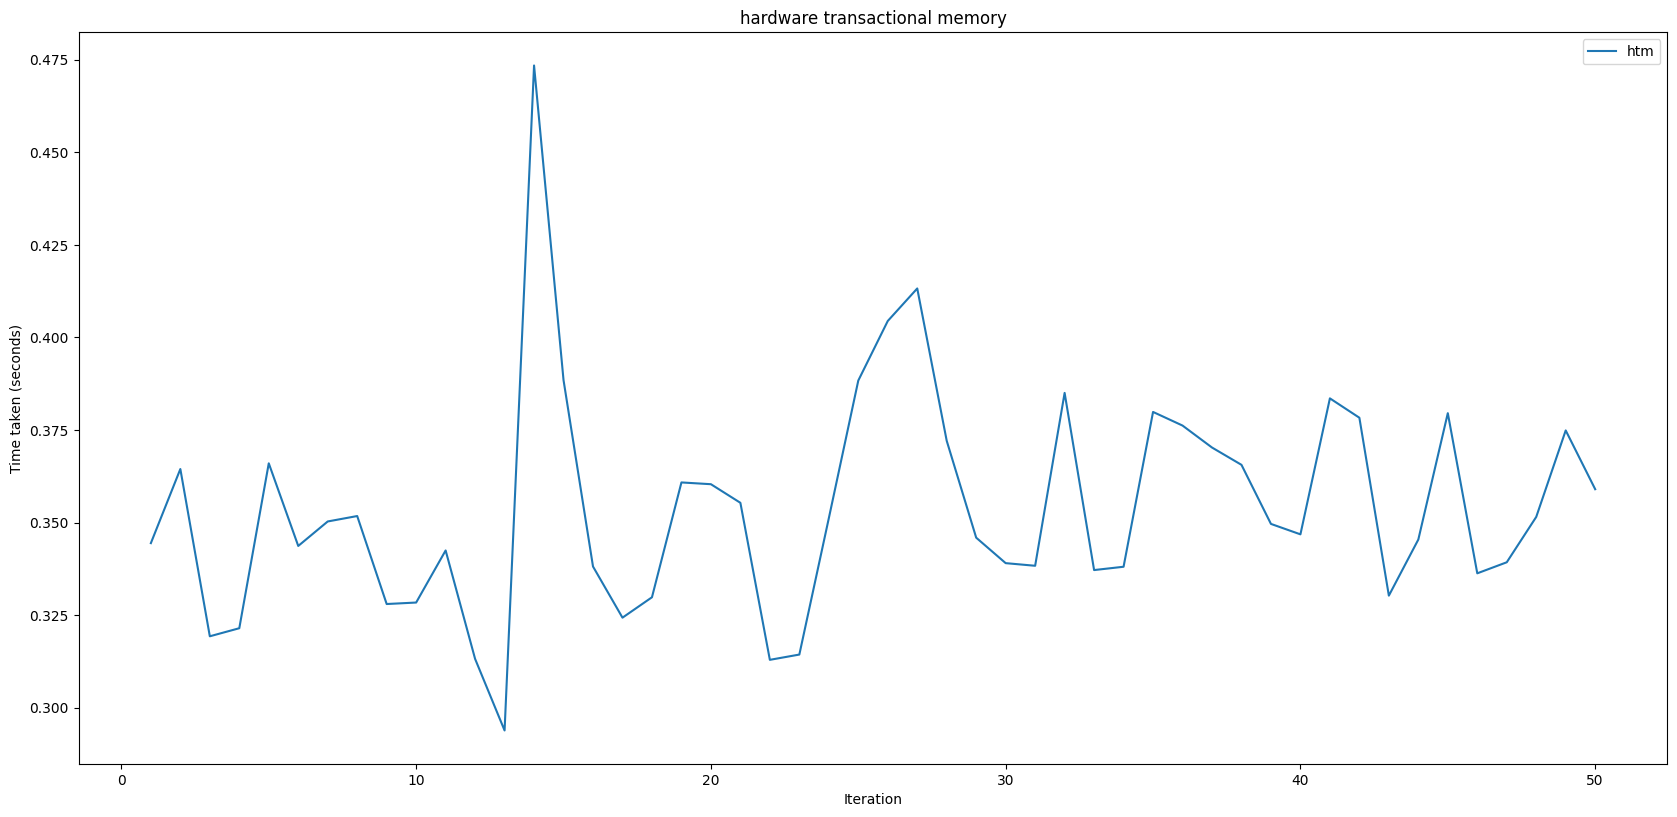

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(range(1, iterations+1), times, label='htm')
ax.set_xlabel('Iteration')
ax.set_ylabel('Time taken (seconds)')

ax.set_title('hardware transactional memory')
ax.legend()
plt.show()